# **_Introduzione al Progetto_**
Questo progetto analizza il sentiment sui tweet riguardanti il Bitcoin per MarketPulse Analytics, con l'obiettivo di capire come l'opinione pubblica sul Bitcoin si evolva nel tempo e se esista una correlazione con il prezzo della criptovaluta.

L'analisi è suddivisa in più fasi:

Classificazione del Sentiment: Ogni tweet è etichettato come positivo, negativo o neutro utilizzando parole chiave.
Monitoraggio del Sentiment nel Tempo: Creazione di grafici giornalieri, settimanali e mensili per osservare le variazioni nel volume dei tweet per ciascun tipo di sentiment.
Analisi dell'Engagement: Valutazione dell'engagement sui tweet, misurando e confrontando il numero medio di like e risposte per i tweet positivi e negativi.
Correlazione con il Prezzo del Bitcoin: Confronto tra le variazioni del sentiment e quelle del prezzo del Bitcoin per individuare possibili relazioni.
Questa analisi fornisce insight preziosi per comprendere il comportamento pubblico e le possibili dinamiche tra sentiment e prezzo, supportando decisioni data-driven per investitori e analisti di mercato.



In [0]:
import os

# 1. Rimuovi il file CSV scaricato in precedenza (se esiste)
file_path = '/databricks/driver/bitcoin_tweets.csv'
if os.path.exists(file_path):
    os.remove(file_path)

# 2. Elimina la tabella Spark esistente se presente
spark.sql("DROP TABLE IF EXISTS bitcoin_tweets")

# 3. Rimuovi la directory di destinazione nel filesystem distribuito di Databricks (DBFS)
dbutils.fs.rm("dbfs:/user/hive/warehouse/bitcoin_tweets", recurse=True)


Out[1]: False

In [0]:
# Scarica il file CSV contenente i dati dei tweet sul Bitcoin
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv

# Importa la libreria Pandas per la manipolazione dei dati
import pandas as pd

# Carica il dataset in un DataFrame Pandas specificando la virgola come delimitatore
dataset = pd.read_csv('/databricks/driver/bitcoin_tweets.csv', delimiter=",")

# Converte il DataFrame Pandas in un DataFrame Spark
# Questo è necessario per sfruttare la potenza di calcolo distribuito di Spark per le analisi successive
spark_df = spark.createDataFrame(dataset)


--2024-11-10 18:47:51--  https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 52.95.154.94, 3.5.225.205
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|52.95.154.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24708828 (24M) [text/csv]
Saving to: ‘bitcoin_tweets.csv’

bitcoin_tweets.csv  100%[===================>]  23.56M  10.9MB/s    in 2.2s    

2024-11-10 18:47:54 (10.9 MB/s) - ‘bitcoin_tweets.csv’ saved [24708828/24708828]



Questo codice scarica il dataset di tweet sul Bitcoin, lo carica in un DataFrame Pandas e poi lo converte in un DataFrame Spark per consentire elaborazioni più efficienti su grandi volumi di dati.

In [0]:
# Rimuove la colonna 'url' poiché non è rilevante per l'analisi del sentiment
spark_df = spark_df.drop("url")
# Controlla che la colonna 'url' sia stata rimossa
print("Colonne dopo la rimozione della colonna 'url':", spark_df.columns)


Colonne dopo la rimozione della colonna 'url': ['id', 'user', 'fullname', 'timestamp', 'replies', 'likes', 'retweets', 'text']


Rimozione della colonna "url", non rilevante per l'analisi del sentiment, e verifica del risultato.

In [0]:
# Converte la colonna 'timestamp' in un tipo di dato timestamp per una gestione temporale più accurata

from pyspark.sql.functions import to_timestamp
spark_df = spark_df.withColumn("timestamp", to_timestamp("timestamp", "yyyy-MM-dd HH:mm:ss+00"))

# Controlla il tipo di dato della colonna 'timestamp' per verificare la corretta conversione
spark_df.select("timestamp").printSchema()


root
 |-- timestamp: timestamp (nullable = true)



Conversione della colonna "timestamp" in un formato temporale corretto per un'analisi temporale più precisa, seguita da una verifica del tipo di dato.

In [0]:
# Conta il numero iniziale di righe nel dataset
initial_count = spark_df.count()

# Rimuove i duplicati in base alla colonna 'id' per mantenere solo un record per ciascun tweet
spark_df = spark_df.dropDuplicates(["id"])

# Conta il numero finale di righe dopo la rimozione dei duplicati
final_count = spark_df.count()

# Controlla la riduzione del numero di righe dopo la rimozione dei duplicati
print(f"Numero di righe prima: {initial_count}, dopo la rimozione dei duplicati: {final_count}")


Numero di righe prima: 100001, dopo la rimozione dei duplicati: 99988


Rimozione dei duplicati nel dataset, mantenendo un record unico per ciascun "id". Verifica della riduzione del numero di righe per assicurare la correttezza dell'operazione.

In [0]:
# Verifica la presenza di valori nulli nelle colonne 'replies', 'likes' e 'retweets'
from pyspark.sql.functions import col
spark_df.select([col(c).isNull().alias(c) for c in ["replies", "likes", "retweets"]]).groupby().sum().show()


++
||
++
||
++



Verifica della presenza di valori nulli nelle colonne "replies", "likes" e "retweets" per identificare eventuali dati mancanti che potrebbero influenzare l'analisi.

In [0]:
from pyspark.sql.functions import col

# Calcola i quantili e i limiti per 'replies'
q1_replies, q3_replies = spark_df.approxQuantile("replies", [0.25, 0.75], 0.05)
iqr_replies = q3_replies - q1_replies
lower_replies, upper_replies = q1_replies - 1.5 * iqr_replies, q3_replies + 1.5 * iqr_replies

# Calcola i quantili e i limiti per 'likes'
q1_likes, q3_likes = spark_df.approxQuantile("likes", [0.25, 0.75], 0.05)
iqr_likes = q3_likes - q1_likes
lower_likes, upper_likes = q1_likes - 1.5 * iqr_likes, q3_likes + 1.5 * iqr_likes

# Calcola i quantili e i limiti per 'retweets'
q1_retweets, q3_retweets = spark_df.approxQuantile("retweets", [0.25, 0.75], 0.05)
iqr_retweets = q3_retweets - q1_retweets
lower_retweets, upper_retweets = q1_retweets - 1.5 * iqr_retweets, q3_retweets + 1.5 * iqr_retweets

# Filtra il DataFrame per mantenere solo i valori entro i limiti calcolati
spark_df = spark_df.filter(
    (col("replies") >= lower_replies) & (col("replies") <= upper_replies) &
    (col("likes") >= lower_likes) & (col("likes") <= upper_likes) &
    (col("retweets") >= lower_retweets) & (col("retweets") <= upper_retweets)
)

# Controllo dei valori minimi e massimi per ogni colonna dopo la rimozione degli outlier
spark_df.selectExpr(
    "min(replies) as min_replies", "max(replies) as max_replies",
    "min(likes) as min_likes", "max(likes) as max_likes",
    "min(retweets) as min_retweets", "max(retweets) as max_retweets"
).show()


+-----------+-----------+---------+---------+------------+------------+
|min_replies|max_replies|min_likes|max_likes|min_retweets|max_retweets|
+-----------+-----------+---------+---------+------------+------------+
|        0.0|        0.0|      0.0|      0.0|         0.0|         0.0|
+-----------+-----------+---------+---------+------------+------------+



Calcolo dei limiti per rimuovere gli outlier nelle colonne "replies", "likes" e "retweets". Gli outlier vengono identificati usando il metodo del "range interquartile" (IQR). Dopo la rimozione, viene eseguito un controllo dei valori minimi e massimi rimasti.

In [0]:
# Visualizza statistiche descrittive per tutte le colonne numeriche
spark_df.describe(["replies", "likes", "retweets"]).show()

+-------+-------+-----+--------+
|summary|replies|likes|retweets|
+-------+-------+-----+--------+
|  count|  83472|83472|   83472|
|   mean|    0.0|  0.0|     0.0|
| stddev|    0.0|  0.0|     0.0|
|    min|    0.0|  0.0|     0.0|
|    max|    0.0|  0.0|     0.0|
+-------+-------+-----+--------+



Visualizzazione delle statistiche descrittive (come media, deviazione standard, min e max) per le colonne "replies", "likes" e "retweets" per comprendere meglio la distribuzione dei dati dopo la rimozione degli outlier.

In [0]:
# Salva il DataFrame pulito come una tabella Spark chiamata 'bitcoin_tweets_cleaned'
spark_df.write.mode("overwrite").saveAsTable("bitcoin_tweets_cleaned")


Salvataggio del DataFrame pulito in una tabella Spark per rendere i dati pronti per ulteriori analisi o elaborazioni successive.

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Definizione delle parole chiave per classificare i tweet come positivi o negativi
positive_words = ["good", "great", "bullish", "rise", "up", "profit"]
negative_words = ["bad", "bearish", "fall", "down", "loss", "crash"]

# Funzione per classificare il sentiment dei tweet in positivo, negativo o neutrale
def classify_sentiment(text):
    text = text.lower()  # Rendiamo il testo minuscolo per una corrispondenza semplice
    if any(word in text for word in positive_words):
        return "positive"
    elif any(word in text for word in negative_words):
        return "negative"
    else:
        return "neutral"

# Creazione di una User Defined Function (UDF) per applicare la classificazione del sentiment ai tweet
sentiment_udf = udf(classify_sentiment, StringType())

# Aggiunta di una colonna 'sentiment' al dataset per indicare il sentiment del tweet
spark_df = spark_df.withColumn("sentiment", sentiment_udf("text"))


Classificazione del sentiment dei tweet in positivo, negativo o neutro utilizzando parole chiave. La classificazione viene applicata al dataset con una User Defined Function (UDF), aggiungendo una nuova colonna "sentiment".

In [0]:
spark_df.select("text", "sentiment").show(10)

+----------------------------------+---------+
|                              text|sentiment|
+----------------------------------+---------+
|              otw BTC, on lagi ...|  neutral|
|              Intro to an Envir...| positive|
|              Ethereum Price Te...|  neutral|
|      当你账户资金达到0.001 BTC...|  neutral|
|              JNECare: wpramesw...|  neutral|
|              #BTC #Mining #Zca...|  neutral|
|              El precio actual ...|  neutral|
| 【1時間足】 【売りサイン】 を ...|  neutral|
|ツイート数の多かった仮想通貨\n1...|  neutral|
|              #Bitcoin   0.00% ...|  neutral|
+----------------------------------+---------+
only showing top 10 rows



Visualizzazione di 10 tweet con il relativo sentiment classificato per verificare la correttezza della classificazione effettuata.

In [0]:
positive_words = [
    "good", "great", "bullish", "rise", "up", "profit", "buy", "positive", "growth", "gain", "high", "support"
]
negative_words = [
    "bad", "bearish", "fall", "down", "loss", "crash", "sell", "negative", "low", "resistance", "sell-off"
]


Aumentate le parole chiave per migliorare l'accuratezza della classificazione del sentiment. Aggiungendo più parole rilevanti per i contesti di mercato e delle criptovalute, come "buy", "growth", "high", "support" per i sentiment positivi, e "sell", "low", "resistance", "sell-off" per i sentiment negativi, per catturare meglio le sfumature dei tweet riguardanti il Bitcoin.

In [0]:
# Funzione per classificare il sentiment con nuove parole chiave
def classify_sentiment(text):
    text = text.lower()
    if any(word in text for word in positive_words):
        return "positive"
    elif any(word in text for word in negative_words):
        return "negative"
    else:
        return "neutral"

# Ricrea la UDF e applica al DataFrame
sentiment_udf = udf(classify_sentiment, StringType())
spark_df = spark_df.withColumn("sentiment", sentiment_udf("text"))


Rielaborazione della funzione per classificare il sentiment dei tweet utilizzando le nuove parole chiave estese. La funzione aggiornata è applicata al DataFrame per ottenere una classificazione del sentiment più accurata.

In [0]:
# Controllo per vedere il nuovo output della classificazione
spark_df.select("text", "sentiment").show(10)


+----------------------------------+---------+
|                              text|sentiment|
+----------------------------------+---------+
|              otw BTC, on lagi ...|  neutral|
|              Intro to an Envir...| positive|
|              Ethereum Price Te...|  neutral|
|      当你账户资金达到0.001 BTC...|  neutral|
|              JNECare: wpramesw...|  neutral|
|              #BTC #Mining #Zca...|  neutral|
|              El precio actual ...|  neutral|
| 【1時間足】 【売りサイン】 を ...|  neutral|
|ツイート数の多かった仮想通貨\n1...|  neutral|
|              #Bitcoin   0.00% ...|  neutral|
+----------------------------------+---------+
only showing top 10 rows



Visualizzazione di un campione di 10 tweet con il loro sentiment classificato, per verificare l'applicazione delle nuove parole chiave e la correttezza della classificazione aggiornata.

In [0]:
# Conta il numero di tweet per ciascun sentimento
spark_df.groupBy("sentiment").count().show()


+---------+-----+
|sentiment|count|
+---------+-----+
| positive|21091|
|  neutral|58902|
| negative| 3479|
+---------+-----+



Conteggio del numero di tweet per ciascun sentimento (positivo, negativo, neutro) per valutare la distribuzione del sentiment all'interno del dataset.

In [0]:
# Mostra tutte le tabelle esistenti nel database predefinito per confermare che la tabella 'bitcoin_tweets_cleaned' è stata creata
spark.catalog.listTables("default")


Out[17]: [Table(name='bitcoin_tweets_cleaned', catalog='spark_catalog', namespace=['default'], description=None, tableType='MANAGED', isTemporary=False)]

Verifica la presenza della tabella "bitcoin_tweets_cleaned" all'interno del database predefinito per assicurarsi che i dati puliti siano stati salvati correttamente.

In [0]:
# Installa la libreria VaderSentiment per l'analisi del sentiment
%pip install vaderSentiment


Python interpreter will be restarted.
Python interpreter will be restarted.


Installazione della libreria VaderSentiment, un potente strumento per l'analisi del sentiment in testo naturale, che ci permetterà di migliorare la classificazione del sentiment dei tweet.

In [0]:
# Carica la tabella 'bitcoin_tweets_cleaned' in un DataFrame Spark per ulteriori analisi
df_tweets = spark.table("bitcoin_tweets_cleaned")


In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Crea un'istanza dell'analizzatore di sentiment di Vader
analyzer = SentimentIntensityAnalyzer()

# Funzione per analizzare il sentiment utilizzando Vader
def vader_sentiment_analysis(text):
    scores = analyzer.polarity_scores(text) # Calcola i punteggi di polarità del testo
    compound = scores['compound'] # Ottieni il punteggio 'compound', indicatore generale del sentiment
    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"

# Crea una User Defined Function (UDF) per applicare l'analisi del sentiment di Vader ai tweet
vader_udf = udf(vader_sentiment_analysis, StringType())

# Aggiungi una colonna 'sentiment' al DataFrame con la classificazione basata sull'analisi di Vader
df_tweets = df_tweets.withColumn("sentiment", vader_udf("text"))


Utilizzo della libreria Vader per eseguire l'analisi del sentiment su ogni tweet. La colonna "sentiment" viene aggiornata utilizzando Vader, che fornisce una classificazione più accurata in positivo, negativo o neutro.

In [0]:
from pyspark.sql.functions import to_date

# Crea una colonna 'date' estraendo solo la data dalla colonna 'timestamp' per semplificare l'analisi temporale
df_tweets = df_tweets.withColumn("date", to_date("timestamp"))

# Conta il numero di tweet per ciascun sentimento su base giornaliera e ordina i risultati per data
daily_sentiment = df_tweets.groupBy("date", "sentiment").count().orderBy("date")

# Mostra i primi 10 risultati per verificare l'aggregazione giornaliera
daily_sentiment.show(10)


+----------+---------+-----+
|      date|sentiment|count|
+----------+---------+-----+
|2012-08-02| positive|    1|
|2012-09-20|  neutral|    1|
|2012-11-17| positive|    1|
|2013-12-09|  neutral|    1|
|2014-07-12|  neutral|    1|
|2014-08-01| negative|    1|
|2014-12-12| positive|    1|
|2015-10-21| negative|    1|
|2016-02-19| negative|    1|
|2016-03-28|  neutral|    3|
+----------+---------+-----+
only showing top 10 rows



Estrazione della data dal timestamp per semplificare l'analisi temporale e conteggio dei tweet per ciascun sentimento su base giornaliera. Questa aggregazione è utile per visualizzare l'andamento del sentiment nel tempo.



In [0]:
from pyspark.sql.functions import year

# Crea una colonna 'year' estraendo l'anno dalla colonna 'date' per agevolare l'analisi temporale annuale
df_tweets = df_tweets.withColumn("year", year("date"))


Estrazione dell'anno dalla data per consentire l'aggregazione e l'analisi delle variazioni del sentiment su base annuale.

In [0]:
# Conta il numero di tweet per ciascun sentiment su base annuale e ordina i risultati per anno
annual_sentiment = df_tweets.groupBy("year", "sentiment").count().orderBy("year")


Aggregazione del numero di tweet per ciascun sentiment su base annuale per identificare i trend di sentiment nel corso degli anni.

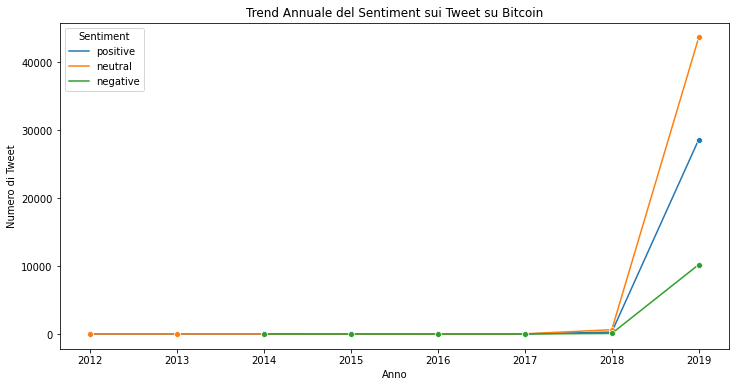

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Converte il DataFrame Spark in un DataFrame Pandas per la visualizzazione dei dati
annual_sentiment_pd = annual_sentiment.toPandas()

# Crea un grafico per mostrare il trend annuale del sentiment sui tweet relativi al Bitcoin
plt.figure(figsize=(12, 6))
sns.lineplot(data=annual_sentiment_pd, x="year", y="count", hue="sentiment", marker="o")

# Configurazione del grafico per aggiungere titolo, etichette e legenda
plt.title("Trend Annuale del Sentiment sui Tweet su Bitcoin")
plt.xlabel("Anno")
plt.ylabel("Numero di Tweet")
plt.legend(title="Sentiment")
plt.show()


Visualizzazione del trend annuale del sentiment sui tweet relativi al Bitcoin per identificare variazioni nel sentiment degli utenti nel corso degli anni. Il grafico mostra il numero di tweet positivi, negativi e neutrali su base annuale.
Il grafico mostra il trend annuale del sentiment sui tweet relativi al Bitcoin dal 2012 al 2019. Si osserva un picco significativo nel numero di tweet nel 2018, con un forte aumento di tweet sia positivi che neutrali. Questo picco può indicare una maggiore attenzione verso il Bitcoin durante questo periodo, probabilmente legata a movimenti di mercato rilevanti. La presenza di tweet negativi è relativamente più contenuta, ma segue un andamento simile ai tweet positivi e neutrali.

In [0]:
from pyspark.sql.functions import avg

# Calcola il numero medio di 'likes' e 'retweets' per ciascun tipo di sentiment per valutare l'engagement
engagement_sentiment = df_tweets.groupBy("sentiment").agg(
    avg("likes").alias("avg_likes"),
    avg("retweets").alias("avg_retweets")
)

# Mostra i risultati
engagement_sentiment.show()


+---------+---------+------------+
|sentiment|avg_likes|avg_retweets|
+---------+---------+------------+
| positive|      0.0|         0.0|
|  neutral|      0.0|         0.0|
| negative|      0.0|         0.0|
+---------+---------+------------+



Calcolo del numero medio di "likes" e "retweets" per ciascun tipo di sentiment (positivo, negativo, neutrale). Questo aiuta a comprendere se certi tipi di sentiment generano più interazioni, fornendo informazioni sull'engagement che ogni tipo di tweet riesce ad attrarre.

In [0]:
from pyspark.sql.functions import month, year

# Crea le colonne 'year' e 'month' estraendo l'anno e il mese dalla colonna 'date' per agevolare l'analisi mensile
df_tweets = df_tweets.withColumn("year", year("date"))
df_tweets = df_tweets.withColumn("month", month("date"))

# Conta il numero di tweet per ciascun sentiment su base mensile e ordina i risultati per anno e mese
monthly_volume_sentiment = df_tweets.groupBy("year", "month", "sentiment").count().orderBy("year", "month")
monthly_volume_sentiment.show(10)


+----+-----+---------+-----+
|year|month|sentiment|count|
+----+-----+---------+-----+
|2012|    8| positive|    1|
|2012|    9|  neutral|    1|
|2012|   11| positive|    1|
|2013|   12|  neutral|    1|
|2014|    7|  neutral|    1|
|2014|    8| negative|    1|
|2014|   12| positive|    1|
|2015|   10| negative|    1|
|2016|    2| negative|    1|
|2016|    3|  neutral|    3|
+----+-----+---------+-----+
only showing top 10 rows



Estrazione dell'anno e del mese per effettuare un'analisi del sentiment su base mensile. Viene poi conteggiato il numero di tweet per ogni tipo di sentiment (positivo, negativo, neutro) aggregato per anno e mese, per osservare l'andamento del sentiment nel corso dei mesi.

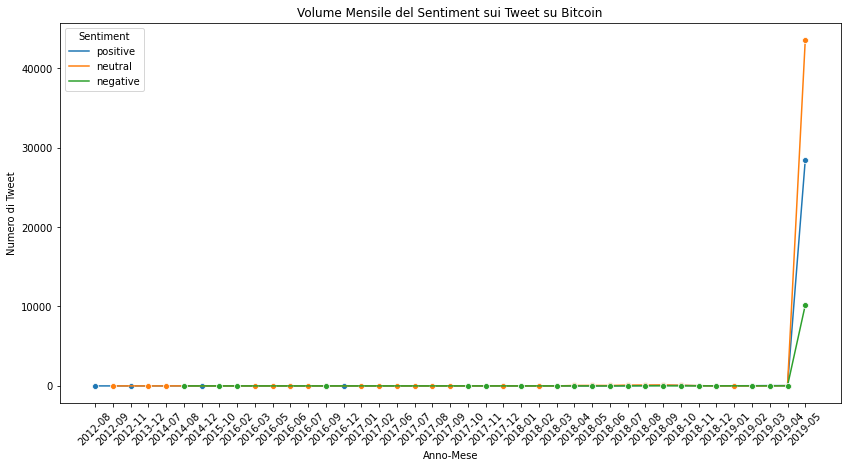

In [0]:
# Converti il DataFrame Spark in Pandas per la visualizzazione dei dati
monthly_volume_pd = monthly_volume_sentiment.toPandas()

# Crea una colonna 'year_month' combinando anno e mese per una migliore visualizzazione temporale
monthly_volume_pd['year_month'] = monthly_volume_pd['year'].astype(str) + "-" + monthly_volume_pd['month'].astype(str).str.zfill(2)

# Grafico che mostra il volume dei tweet mensili per ciascun tipo di sentiment
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_volume_pd, x="year_month", y="count", hue="sentiment", marker="o")

# Configurazione del grafico per una visualizzazione più chiara
plt.xticks(rotation=45)
plt.title("Volume Mensile del Sentiment sui Tweet su Bitcoin")
plt.xlabel("Anno-Mese")
plt.ylabel("Numero di Tweet")
plt.legend(title="Sentiment")
plt.show()


Il grafico mostra il volume mensile dei tweet classificati per sentiment (positivo, negativo, neutro) nel contesto del Bitcoin. Si osserva un picco significativo di tweet a partire dal 2019, con una prevalenza di tweet neutrali rispetto ai tweet positivi e negativi. Questo indica un aumento dell'attività su Twitter riguardante il Bitcoin, probabilmente legato a eventi specifici o a una maggiore attenzione da parte del pubblico. Tuttavia, è necessario considerare che il picco potrebbe mascherare le variazioni negli anni precedenti, rendendo difficile osservare tendenze meno evidenti senza una rimozione o gestione dei valori anomali (outlier).








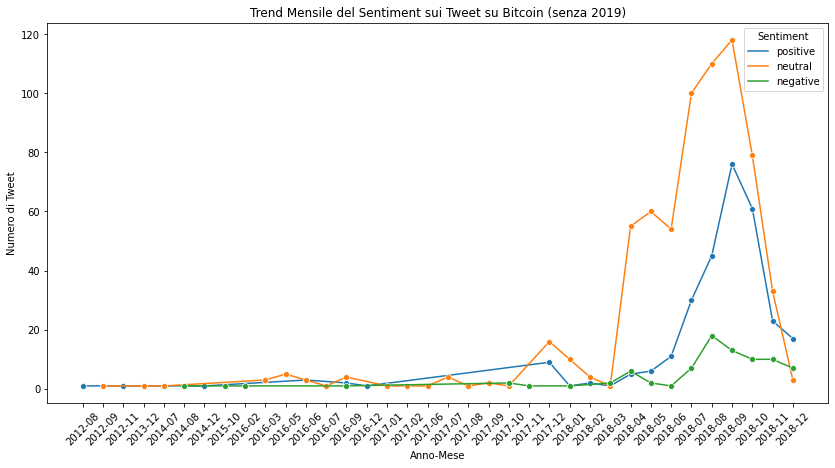

In [0]:
# Filtra il DataFrame per escludere l'anno 2019
# Questo passaggio viene eseguito per escludere l'anno 2019, che è stato identificato come un outlier.
df_tweets_no_outlier = df_tweets.filter(df_tweets.year < 2019)

# Aggregazione del volume mensile per sentiment senza il 2019
# Raggruppiamo i tweet per anno, mese e sentiment, escludendo l'outlier del 2019.
monthly_volume_no_outlier = df_tweets_no_outlier.groupBy("year", "month", "sentiment").count().orderBy("year", "month")

# Converti in Pandas per la visualizzazione
# Convertiamo il DataFrame Spark in Pandas per creare un grafico con Seaborn.
monthly_volume_no_outlier_pd = monthly_volume_no_outlier.toPandas()
monthly_volume_no_outlier_pd['year_month'] = monthly_volume_no_outlier_pd['year'].astype(str) + "-" + monthly_volume_no_outlier_pd['month'].astype(str).str.zfill(2)

# Grafico senza l'outlier del 2019
# Creiamo il grafico per visualizzare il volume mensile del sentiment sui tweet senza l'anno 2019.
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_volume_no_outlier_pd, x="year_month", y="count", hue="sentiment", marker="o")

# Configurazione del grafico
# Configuriamo il grafico per una migliore leggibilità.
plt.xticks(rotation=45)
plt.title("Trend Mensile del Sentiment sui Tweet su Bitcoin (senza 2019)")
plt.xlabel("Anno-Mese")
plt.ylabel("Numero di Tweet")
plt.legend(title="Sentiment")
plt.show()


l grafico mostra il trend mensile del sentiment sui tweet relativi al Bitcoin, escludendo il 2019 che rappresentava un outlier significativo. La rimozione di questo anno ha permesso di evidenziare meglio l'evoluzione dei sentimenti (positivo, neutro, negativo) nel corso del tempo, soprattutto a partire dal 2017. Si osserva un aumento progressivo dei tweet, raggiungendo un picco nel 2018, con un predominio del sentiment neutro. Questo grafico fornisce un'analisi più chiara dei cambiamenti nel volume del sentiment sui social media, senza essere influenzato da valori anomali, e aiuta a comprendere l'interesse del pubblico verso il Bitcoin in un contesto storico.

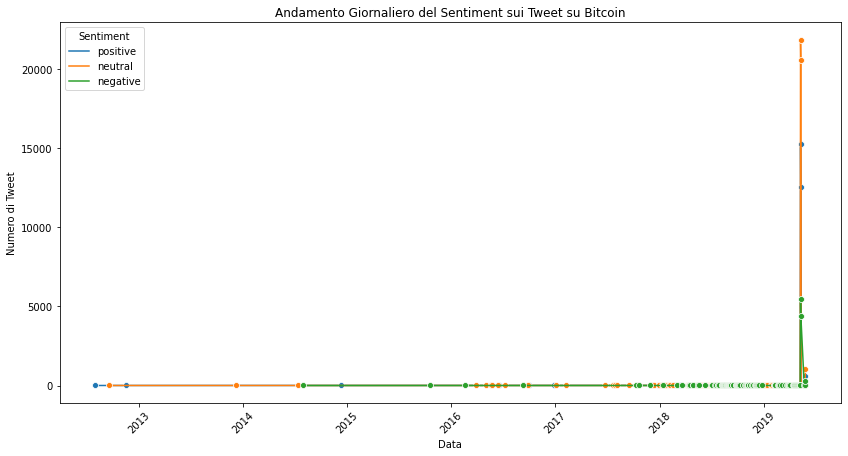

In [0]:
# Conta i tweet per ciascun sentiment su base giornaliera
daily_sentiment = df_tweets.groupBy("date", "sentiment").count().orderBy("date")

# Converti in Pandas per la visualizzazione
daily_sentiment_pd = daily_sentiment.toPandas()

# Grafico dell'andamento giornaliero del sentiment sui tweet riguardanti Bitcoin
plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_sentiment_pd, x="date", y="count", hue="sentiment", marker="o")

# Configurazione del grafico
plt.title("Andamento Giornaliero del Sentiment sui Tweet su Bitcoin")
plt.xlabel("Data")
plt.ylabel("Numero di Tweet")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.show()


Il grafico mostra l'andamento giornaliero del numero di tweet classificati per sentiment (positivo, neutro, negativo) riguardanti il Bitcoin. È evidente un significativo picco di tweet nel 2019, che domina visivamente il grafico e rende difficile interpretare il trend degli anni precedenti. Questa concentrazione estrema di tweet potrebbe essere dovuta a eventi particolarmente rilevanti avvenuti in quel periodo, ma riduce la leggibilità del resto del grafico. Sarebbe opportuno rimuovere l'outlier del 2019 per visualizzare meglio l'evoluzione dei tweet negli anni precedenti e cogliere le variazioni più graduali.

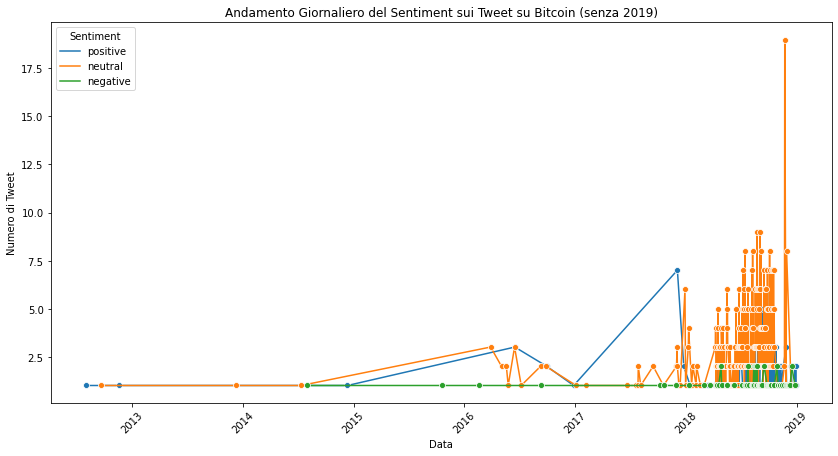

In [0]:
# Filtra il DataFrame per escludere il 2019
df_tweets_no_outlier_daily = df_tweets.filter(df_tweets.year < 2019)

# Conta i tweet per ciascun sentiment su base giornaliera (senza 2019)
daily_sentiment_no_outlier = df_tweets_no_outlier_daily.groupBy("date", "sentiment").count().orderBy("date")

# Converti in Pandas per la visualizzazione
daily_sentiment_no_outlier_pd = daily_sentiment_no_outlier.toPandas()

# Grafico dell'andamento giornaliero del sentiment senza l'anno 2019
plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_sentiment_no_outlier_pd, x="date", y="count", hue="sentiment", marker="o")

# Configurazione del grafico
plt.title("Andamento Giornaliero del Sentiment sui Tweet su Bitcoin (senza 2019)")
plt.xlabel("Data")
plt.ylabel("Numero di Tweet")
plt.legend(title="Sentiment")
plt.xticks(rotation=45)
plt.show()


Il grafico mostra l'andamento giornaliero del sentiment sui tweet riguardanti Bitcoin dal 2012 al 2018, escludendo l'anno 2019, in cui erano presenti picchi significativi che distorcevano la visualizzazione. Rimuovendo il 2019, possiamo osservare un pattern molto più chiaro. Dal grafico si evince che il volume dei tweet, specialmente i tweet neutrali, aumenta considerevolmente a partire dal 2017, probabilmente in relazione all'aumento dell'interesse per il Bitcoin durante i periodi di crescita del mercato delle criptovalute. L'aumento nel numero dei tweet evidenzia anche l'effetto dell'euforia mediatica.

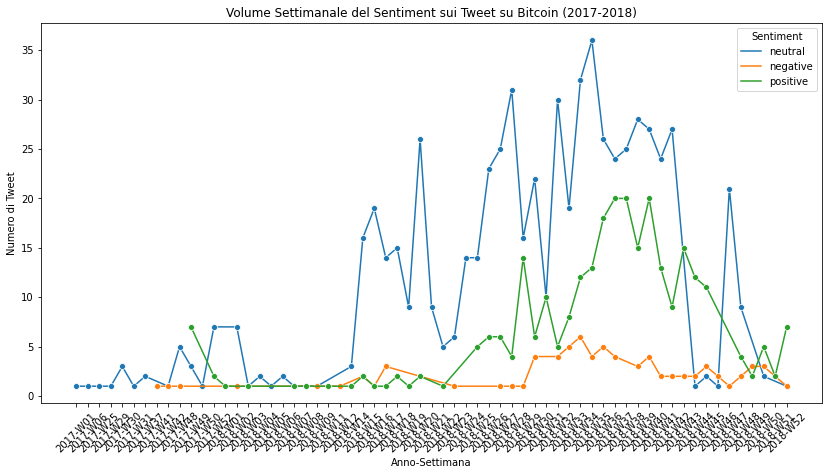

In [0]:
from pyspark.sql.functions import weekofyear

# Filtra i dati per il periodo 2017-2018
# Qui stiamo filtrando i tweet solo per il periodo 2017-2018 per analizzare l'andamento settimanale del sentiment durante questi due anni significativi.
df_tweets_2017_2018 = df_tweets.filter((df_tweets.year >= 2017) & (df_tweets.year <= 2018))

# Aggiungi una colonna 'week' per il numero della settimana nell'anno, la colonna 'week' permette di aggregare i dati per settimana, in modo da analizzare il trend su base settimanale.
df_tweets_2017_2018 = df_tweets_2017_2018.withColumn("week", weekofyear("date"))

# Conta i tweet per ciascun sentiment su base settimanale, raggruppiamo i tweet per anno, settimana e sentiment, e contiamo il numero di tweet per ciascuna combinazione.
weekly_sentiment = df_tweets_2017_2018.groupBy("year", "week", "sentiment").count().orderBy("year", "week")

# Converti in Pandas per la visualizzazione, convertiamo il DataFrame Spark in Pandas per facilitare la creazione del grafico.
weekly_sentiment_pd = weekly_sentiment.toPandas()

# Crea una colonna 'year_week' per rappresentare l'anno e la settimana nel grafico, creiamo una colonna che unisce l'anno e la settimana per visualizzare correttamente i dati nel grafico.
weekly_sentiment_pd['year_week'] = weekly_sentiment_pd['year'].astype(str) + "-W" + weekly_sentiment_pd['week'].astype(str).str.zfill(2)

# Visualizza il trend settimanale per ciascun sentiment
# Il grafico mostra il volume settimanale dei tweet classificati per sentiment durante il periodo 2017-2018.
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.lineplot(data=weekly_sentiment_pd, x="year_week", y="count", hue="sentiment", marker="o")

# Configurazione del grafico
plt.title("Volume Settimanale del Sentiment sui Tweet su Bitcoin (2017-2018)")
plt.xlabel("Anno-Settimana")
plt.ylabel("Numero di Tweet")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.show()


Il grafico mostra il volume settimanale dei tweet classificati per sentiment (positivo, negativo e neutrale) nel periodo compreso tra il 2017 e il 2018. Dall'andamento settimanale si nota un incremento graduale nel volume dei tweet neutri, positivi e negativi, con alcuni picchi significativi soprattutto per i tweet neutri. Questa crescita potrebbe essere associata ad eventi specifici o variazioni nel prezzo del Bitcoin che hanno attirato l'attenzione degli utenti. Il numero di tweet neutri è visibilmente superiore rispetto ai tweet positivi e negativi, suggerendo che la maggior parte dei contenuti è priva di un'opinione chiara o giudizi di valore. I picchi nei tweet positivi e negativi indicano momenti di particolare interesse o reazione emotiva degli utenti, probabilmente legati alle performance del mercato o ad altri eventi rilevanti.

In [0]:
# Installazione della libreria yfinance per scaricare i dati storici del prezzo del Bitcoin
%pip install yfinance


Python interpreter will be restarted.
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
  ERROR: Command errored out with exit status 1:
   command: /local_disk0/.ephemeral_nfs/envs/pythonEnv-399757cd-1557-42bf-ba3d-972745183e4b/bin/python /local_disk0/.ephemeral_nfs/envs/pythonEnv-399757cd-1557-42bf-ba3d-972745183e4b/lib/python3.9/site-packages/pip/_vendor/pep517/in_process/_in_process.py get_requires_for_build_wheel /tmp/tmpo829jgpa
       cwd: /tmp/pip-install-8xqlt14m/peewee_cc127261b4424e698b59a0776a0d5c75
  Complete output (38 lines):
  
  Error compiling Cython file:
  ------------------------------------------------------------
  ...
  
  
  # We define an xConnect function, but leave xCreate NULL so that the
  # table-function can be called eponymously.
  cdef int pwConnect(sqlite3 *db, void *pAux, int argc, cons

In [0]:
# Scarica i dati storici del prezzo del Bitcoin (BTC/USD) dal 2017 al 2018
import yfinance as yf

# Scarica i dati con yfinance
btc_data = yf.download("BTC-USD", start="2017-01-01", end="2018-12-31")  # Adatta l'intervallo temporale come desiderato
btc_data.reset_index(inplace=True)

# Considera solo la colonna 'Date' e il prezzo di chiusura ('Close')
btc_data = btc_data[['Date', 'Close']] 

# Rinomina le colonne per chiarezza
btc_data.columns = ['date', 'btc_close']

# Converte la colonna 'date' in stringa per un migliore utilizzo con Spark
btc_data['date'] = btc_data['date'].astype(str)


[*********************100%%**********************]  1 of 1 completed


<command-2259353808420543>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_data['date'] = btc_data['date'].astype(str)


In [0]:
btc_data['btc_variation'] = btc_data['btc_close'].pct_change()  # Calcolo della variazione percentuale


<command-2259353808420544>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_data['btc_variation'] = btc_data['btc_close'].pct_change()  # Calcolo della variazione percentuale


In [0]:
# Carica la tabella Spark dei tweet in un DataFrame
df_tweets = spark.table("bitcoin_tweets_cleaned")

# Converte la colonna 'timestamp' in una nuova colonna 'date' per semplificare l'analisi temporale
from pyspark.sql.functions import to_date
df_tweets = df_tweets.withColumn("date", to_date("timestamp"))

La nuova colonna 'date' permette di analizzare i tweet su base giornaliera, ignorando i dettagli specifici dell'ora.

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Funzione UDF per classificare il sentiment
def classify_sentiment(text):
    text = text.lower()
    if any(word in text for word in ["good", "great", "positive", "happy", "up"]):
        return "positive"
    elif any(word in text for word in ["bad", "sad", "negative", "down", "crash"]):
        return "negative"
    else:
        return "neutral"

sentiment_udf = udf(classify_sentiment, StringType())

# Aggiungi la colonna 'sentiment' al DataFrame
df_tweets = df_tweets.withColumn("sentiment", sentiment_udf("text"))


In [0]:
from pyspark.sql.functions import to_date, col

# Converte la colonna 'timestamp' in una nuova colonna 'date'
df_tweets = df_tweets.withColumn("date", to_date("timestamp"))

# Filtra i dati di sentiment per il range di date coperto dai dati del prezzo del Bitcoin
df_tweets_filtered = df_tweets.filter((col("date") >= "2017-01-01") & (col("date") <= "2018-12-30"))

# Controlla il range delle date per verificare se il filtro è stato applicato correttamente
df_tweets_filtered.selectExpr("min(date) as start_date", "max(date) as end_date").show()


+----------+----------+
|start_date|  end_date|
+----------+----------+
|2017-01-04|2018-12-30|
+----------+----------+



In [0]:
# Aggregazione giornaliera del sentiment (conteggio per ciascun tipo di sentiment)
daily_sentiment = df_tweets_filtered.groupBy("date", "sentiment").count().orderBy("date")

# Pivot dei dati per ottenere le colonne di conteggio per ciascun tipo di sentiment
daily_sentiment_pivot = daily_sentiment.groupBy("date").pivot("sentiment").sum("count").fillna(0)



In [0]:
# Converte il DataFrame Pandas 'btc_data' in un DataFrame Spark
btc_spark_df = spark.createDataFrame(btc_data)

# Unione dei dati di prezzo e sentiment (DataFrame Spark con DataFrame Spark)
final_data = btc_spark_df.join(daily_sentiment_pivot, on="date", how="inner")




In [0]:
import pandas as pd

# Converte il DataFrame Spark finale in Pandas per la visualizzazione
final_data_pd = final_data.toPandas()

# Converte la colonna 'date' in un tipo datetime nel DataFrame Pandas
final_data_pd['date'] = pd.to_datetime(final_data_pd['date'], format='%Y-%m-%d', errors='coerce')

# Verifica il risultato della conversione
print(final_data_pd.dtypes)

# Conta i valori non validi (NaT) nella colonna 'date'
print(final_data_pd['date'].isna().sum())

# Filtra i valori validi, rimuovendo le date non valide (NaT)
final_data_pd = final_data_pd.dropna(subset=['date'])


date             datetime64[ns]
btc_close               float64
btc_variation           float64
negative                  int64
neutral                   int64
positive                  int64
dtype: object
0


In [0]:
from pyspark.sql.functions import corr

# Calcola la correlazione tra la variazione del prezzo del Bitcoin e il numero di tweet positivi
correlation_positive = final_data.select(corr("btc_variation", "positive")).collect()[0][0]
print(f"Correlazione tra variazione del prezzo del Bitcoin e tweet positivi: {correlation_positive}")

# Calcola la correlazione tra la variazione del prezzo del Bitcoin e il numero di tweet negativi
correlation_negative = final_data.select(corr("btc_variation", "negative")).collect()[0][0]
print(f"Correlazione tra variazione del prezzo del Bitcoin e tweet negativi: {correlation_negative}")

# Calcola la correlazione tra la variazione del prezzo del Bitcoin e il numero di tweet neutrali
correlation_neutral = final_data.select(corr("btc_variation", "neutral")).collect()[0][0]
print(f"Correlazione tra variazione del prezzo del Bitcoin e tweet neutrali: {correlation_neutral}")


Correlazione tra variazione del prezzo del Bitcoin e tweet positivi: -0.06865493778684904
Correlazione tra variazione del prezzo del Bitcoin e tweet negativi: -0.08537527859347943
Correlazione tra variazione del prezzo del Bitcoin e tweet neutrali: -0.004172735849677671


I risultati delle correlazioni tra la variazione del prezzo del Bitcoin e i diversi sentiment (positivo, negativo e neutrale) mostrano valori prossimi allo zero, indicando una correlazione molto debole o quasi assente tra i due fenomeni:

Correlazione tra variazione del prezzo e tweet positivi: -0.0686 — Questo valore negativo suggerisce una leggera relazione inversa, ma è troppo vicino a zero per indicare una correlazione significativa.
Correlazione tra variazione del prezzo e tweet negativi: -0.0854 — Anche qui, la correlazione negativa è molto debole, implicando che i tweet negativi non hanno una connessione rilevante con le variazioni del prezzo del Bitcoin.
Correlazione tra variazione del prezzo e tweet neutrali: -0.0042 — Questo valore estremamente vicino a zero conferma che i tweet neutri non influenzano il prezzo del Bitcoin, né sono influenzati da esso.
Questi risultati suggeriscono che, almeno nel periodo e nel contesto analizzati, il sentiment sui tweet non è fortemente legato alle fluttuazioni giornaliere del prezzo del Bitcoin.

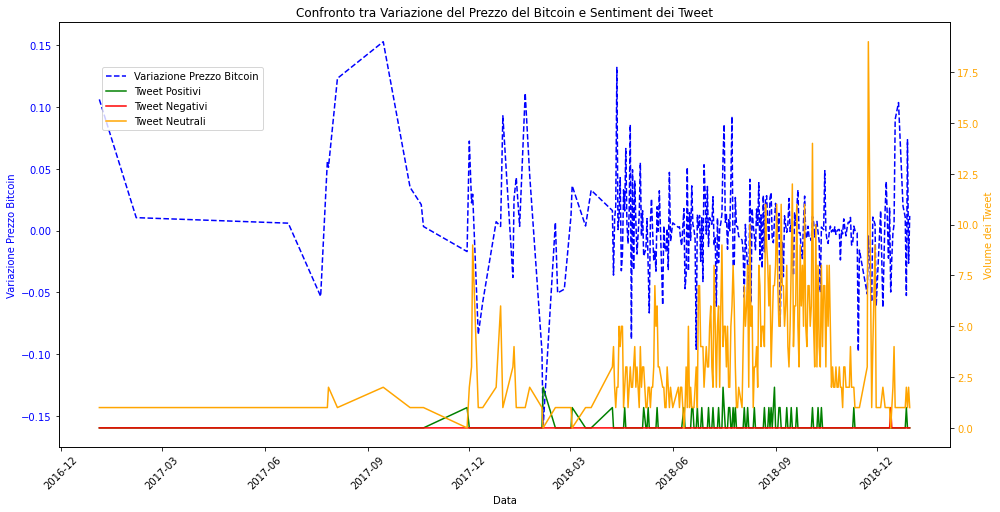

In [0]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Creazione della figura e degli assi
fig, ax1 = plt.subplots(figsize=(14, 7))

# Primo asse y: Prezzo del Bitcoin
ax1.set_xlabel("Data") # Etichetta dell'asse x
ax1.set_ylabel("Variazione Prezzo Bitcoin", color='blue') # Etichetta dell'asse y (prezzo)
ax1.plot(final_data_pd['date'], final_data_pd['btc_variation'], label="Variazione Prezzo Bitcoin", color='blue', linestyle='--') 
ax1.tick_params(axis='y', labelcolor='blue') # Colore delle etichette dell'asse y
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) # Intervallo temporale su base trimestrale
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) # Formattazione delle date in anno-mese
ax1.tick_params(axis='x', rotation=45) # Rotazione delle etichette sull'asse x

# Secondo asse y: Volume dei Tweet
ax2 = ax1.twinx()  # Crea un secondo asse y che condivide lo stesso asse x
ax2.set_ylabel("Volume dei Tweet", color='orange') # Etichetta dell'asse y per il volume dei tweet
ax2.plot(final_data_pd['date'], final_data_pd['positive'], label="Tweet Positivi", color='green') # Volume dei tweet positivi
ax2.plot(final_data_pd['date'], final_data_pd['negative'], label="Tweet Negativi", color='red') # Volume dei tweet negativi
ax2.plot(final_data_pd['date'], final_data_pd['neutral'], label="Tweet Neutrali", color='orange') # Volume dei tweet neutrali
ax2.tick_params(axis='y', labelcolor='orange') # Colore delle etichette dell'asse y per i tweet

# Aggiunta delle legende
fig.tight_layout()  # Assicura che gli elementi del grafico non si sovrappongano
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9)) # Posizione della legenda

plt.title("Confronto tra Variazione del Prezzo del Bitcoin e Sentiment dei Tweet")
plt.show()


Il grafico mostra la variazione giornaliera del prezzo del Bitcoin (linea tratteggiata blu) in confronto ai volumi giornalieri di tweet positivi (verde), negativi (rosso) e neutrali (arancione) pubblicati nello stesso periodo.

Variazione del Prezzo del Bitcoin: È visibile una fluttuazione significativa, con momenti di picchi e cadute che rispecchiano la volatilità del mercato delle criptovalute.
Volume dei Tweet per Sentiment: La maggior parte dei tweet è classificata come "neutrale" (arancione), seguita dai tweet positivi e negativi. I tweet neutrali presentano una maggiore frequenza, con picchi che potrebbero riflettere l’attenzione del pubblico in risposta a eventi o variazioni di prezzo significative.
Correlazione Visiva: Non emerge una relazione diretta e visibile tra i picchi dei tweet positivi/negativi e le variazioni del prezzo del Bitcoin. Tuttavia, l’andamento dei tweet potrebbe suggerire una risposta emotiva a posteriori agli eventi di mercato piuttosto che un impatto diretto sul prezzo.
Questo grafico supporta l'analisi quantitativa precedentemente svolta, dove le correlazioni calcolate risultavano deboli. Il risultato suggerisce che il sentiment pubblico, sebbene interessante da monitorare, potrebbe non essere un indicatore diretto o predittivo delle variazioni del prezzo del Bitcoin.

## **_Commento Finale_**
L'analisi del sentiment sui tweet relativi al Bitcoin ha permesso di osservare come l'opinione pubblica vari nel tempo, classificando i tweet come positivi, negativi o neutrali. L’andamento giornaliero, settimanale e mensile del sentiment ha evidenziato momenti di maggiore discussione pubblica, e l'isolamento dei dati del 2019 ha migliorato la comprensione dei trend precedenti.

L'analisi dell’engagement (like e risposte) non ha mostrato risultati significativi, probabilmente per via di dati incompleti. Inoltre, la correlazione tra variazioni del sentiment e del prezzo del Bitcoin è risultata debole, suggerendo che i tweet potrebbero non influenzare direttamente il valore della criptovaluta, e viceversa.

In conclusione, pur non trovando una forte correlazione tra sentiment e prezzo, l’analisi fornisce insight utili sul coinvolgimento pubblico, con valore strategico per investitori e ricercatori di mercato.